In [1]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
GOOGLE_API_KEY = os.getenv("GOOGLE_API_KEY")
TAVILY_API_KEY = os.getenv("TAVILY_API_KEY")
GROQ_API_KEY = os.getenv("GROQ_API_KEY")
LANGCHAIN_API_KEY = os.getenv("LANGCHAIN_API_KEY")
LANGCHAIN_PROJECT = os.getenv("LANGCHAIN_PROJECT")
LANGSMITH_TRACING="true"
LANGSMITH_ENDPOINT="https://api.smith.langchain.com"
LANGSMITH_API_KEY= os.getenv("LANGSMITH_API_KEY")

In [3]:
from langchain_groq import ChatGroq
llm = ChatGroq(model_name="Llama3-8b-8192")

In [4]:
from langchain_community.tools import DuckDuckGoSearchResults
duck_duck_tool = DuckDuckGoSearchResults()

In [5]:
from langchain_core.tools import tool
from pydantic import BaseModel, Field
from langgraph.graph import MessagesState, StateGraph, END
from langgraph.prebuilt import ToolNode
from langchain_core.messages import HumanMessage

In [6]:
@tool
def get_city_details(prompt):
    "Should do a web search to find the required city details"
    response = duck_duck_tool.invoke(prompt)
    return response

In [7]:
tools = [get_city_details]

In [8]:
model_with_tools = llm.bind_tools(tools)

In [9]:
class CityDetails(BaseModel):
    """Respond to the user with this"""
    state_name: str = Field(description="State name of the city")
    state_capital: str = Field(description="State capital of the city")
    country_name: str = Field(description="Country name of the city")
    country_capital: str = Field(description="Country capital of the city")

In [10]:
# Inherit 'messages' key from MessagesState, which is a list of chat messages
class AgentState(MessagesState):
    # Final structured response from the output
    final_response: CityDetails

In [11]:
model_with_structured_output = llm.with_structured_output(CityDetails)

In [12]:
def call_model(state: AgentState):
    print(f"This is 01 input from call model {state}")
    response = model_with_tools.invoke(state['messages'])
    print(f"This is 02 response from call model {response}")
    return {"messages": [response]}

In [13]:
def should_continue(state: AgentState):
    messages = state['messages']
    last_message = messages[-1]
    
    if not last_message.tool_calls:
        return 'respond'
    else:
        return 'continue'

In [14]:
def respond(state: AgentState):
    print(f"This is 03 state from respond {state}")
    response = model_with_structured_output.invoke([HumanMessage(content=state['messages'][-1].content)])
    print(f"This is 04 response from respond {response}")
    return {"final_response": response}

In [15]:
workflow = StateGraph(AgentState)

workflow.add_node("llm", call_model)
workflow.add_node("tools", ToolNode(tools))
workflow.add_node("respond", respond)
workflow.set_entry_point("llm")
workflow.add_conditional_edges("llm", should_continue, {"continue":"tools", "respond":"respond"})
workflow.add_edge("tools","llm")
workflow.add_edge("respond", END)
graph = workflow.compile()

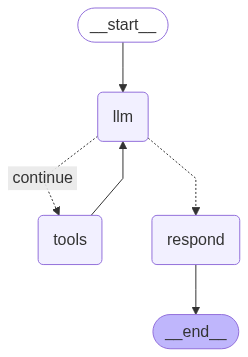

In [16]:
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [17]:
answer = graph.invoke(input={"messages":[("human", "Tell me about the city details for gwalior.")]})

This is 01 input from call model {'messages': [HumanMessage(content='Tell me about the city details for gwalior.', additional_kwargs={}, response_metadata={}, id='447621b9-4fbe-4083-908a-93d681ab7d4c')]}
This is 02 response from call model content='' additional_kwargs={'tool_calls': [{'id': 'call_yg3f', 'function': {'arguments': '{"prompt":"Gwalior"}', 'name': 'get_city_details'}, 'type': 'function'}]} response_metadata={'token_usage': {'completion_tokens': 76, 'prompt_tokens': 906, 'total_tokens': 982, 'completion_time': 0.063333333, 'prompt_time': 0.170740351, 'queue_time': 0.39639136999999997, 'total_time': 0.234073684}, 'model_name': 'Llama3-8b-8192', 'system_fingerprint': 'fp_dadc9d6142', 'finish_reason': 'tool_calls', 'logprobs': None} id='run--07ade392-4334-4b40-86a8-c95d659b942d-0' tool_calls=[{'name': 'get_city_details', 'args': {'prompt': 'Gwalior'}, 'id': 'call_yg3f', 'type': 'tool_call'}] usage_metadata={'input_tokens': 906, 'output_tokens': 76, 'total_tokens': 982}
This is

In [19]:
answer['final_response']

CityDetails(state_name='Madhya Pradesh', state_capital='Bhopal', country_name='India', country_capital='New Delhi')

In [20]:
answer['messages']

[HumanMessage(content='Tell me about the city details for gwalior.', additional_kwargs={}, response_metadata={}, id='447621b9-4fbe-4083-908a-93d681ab7d4c'),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_yg3f', 'function': {'arguments': '{"prompt":"Gwalior"}', 'name': 'get_city_details'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 76, 'prompt_tokens': 906, 'total_tokens': 982, 'completion_time': 0.063333333, 'prompt_time': 0.170740351, 'queue_time': 0.39639136999999997, 'total_time': 0.234073684}, 'model_name': 'Llama3-8b-8192', 'system_fingerprint': 'fp_dadc9d6142', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--07ade392-4334-4b40-86a8-c95d659b942d-0', tool_calls=[{'name': 'get_city_details', 'args': {'prompt': 'Gwalior'}, 'id': 'call_yg3f', 'type': 'tool_call'}], usage_metadata={'input_tokens': 906, 'output_tokens': 76, 'total_tokens': 982}),
 ToolMessage(content="Error: DuckDuckGoSearchException(RatelimitExceptio